# Pharmaceutical Text Review

### Background

The intent of this excercise is ultimately to predict the review score of a drug review based on the user's freeform review. While going through this process, I will also conduct a sentiment analysis (reviewing both the true sentiment of the review as well as the user-prescribed sentiment). The data is provided already split in 75/25 train/test split

In addition, the following data dictionary was provided with the dataset (with formatting edits):

#### Attribute Information:
1. drugName (categorical): name of drug 
2. condition (categorical): name of condition 
3. review (text): patient review 
4. rating (numerical): 10 star patient rating 
5. date (date): date of review entry 
6. usefulCount (numerical): number of users who found review useful


Citation to the original data is below:
Felix Gräßer, Surya Kallumadi, Hagen Malberg, and Sebastian Zaunseder. 2018. Aspect-Based Sentiment Analysis of Drug Reviews Applying Cross-Domain and Cross-Data Learning. In Proceedings of the 2018 International Conference on Digital Health (DH '18). ACM, New York, NY, USA, 121-125. DOI: [Web Link](https://doi.org/10.1145/3194658.3194677)

### Import Modules

In [20]:
import pandas as pd
import numpy as np
import re
import nltk
from afinn import Afinn
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
# from spellchecker import SpellChecker ## not required
import tensorflow as tf
# nltk.download('vader_lexicon')
# nltk.download('punkt')
%matplotlib inline

In [21]:
## Test for GPU 
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Import Data

In [22]:
## Import the train and test data, assign an ID, and join them for easier processing

#train = pd.read_csv('../data/drugsCom_raw/drugsComTrain_raw.tsv', delimiter = '\t', 
#                    index_col = 0).reset_index(drop = True)
#train['ID'] = 'train'

train = pd.read_csv('drugsComTrain_raw.tsv', delimiter = '\t', 
                    index_col = 0).reset_index(drop = True)
train['ID'] = 'train'


#test = pd.read_csv('../data/drugsCom_raw/drugsComTrain_raw.tsv', delimiter = '\t', 
#                   index_col = 0).reset_index(drop = True)
#test['ID'] = 'test'

test = pd.read_csv('drugsComTrain_raw.tsv', delimiter = '\t', 
                   index_col = 0).reset_index(drop = True)
test['ID'] = 'test'

fullDat = train.append(test).reset_index(drop = True)

In [23]:
fullDat.head()

,drugName,condition,review,rating,date,usefulCount,ID
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27,train
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,train
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,train
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,train
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37,train


In [24]:
fullDat.rating.value_counts()

10.0    101978
9.0      55062
1.0      43238
8.0      37780
7.0      18912
5.0      16026
2.0      13862
3.0      13026
6.0      12686
4.0      10024
Name: rating, dtype: int64

In [25]:
## Ratings are all intergers so converting away from the float they currently are
fullDat.rating = fullDat.rating.astype('int')

In [26]:
fullDat.head()

,drugName,condition,review,rating,date,usefulCount,ID
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,"May 20, 2012",27,train
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,"April 27, 2010",192,train
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,"December 14, 2009",17,train
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,"November 3, 2015",10,train
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,"November 27, 2016",37,train


### Clean Text

The review's provided are not very clean with formatting provided for non-alphanumeric characters. Rather than using regex, manually removing to set to obtain a correct word. Rather than replace `I&#039;m` to `Im` with regex, manually replacing to `I'm`.

In [27]:
## Loop over each review and, if the review has a string that matches the regex pattern, add to set for review
## Regex pattern looks for &, then any number of characters up to a ;

fixCount = {}

find = re.compile('(&.*?;)')

for index, row in fullDat.iterrows():
    regexOut = find.findall(row['review'])
    for item in regexOut:
        fixCount[item] = fixCount.get(item, 0) + 1

In [28]:
fixCount

{'&#039;': 524830,
 '&Iacute;': 2,
 '&Prime;': 4,
 '&aacute;': 2,
 '&acirc;': 2,
 '&acute;': 46,
 '&agrave;': 10,
 '&amp;': 26094,
 '&bull;': 104,
 '&deg;': 20,
 '&divide;': 4,
 '&eacute;': 222,
 '&ecirc;': 2,
 '&egrave;': 16,
 '&euro;': 24,
 '&frac12;': 30,
 '&frac14;': 4,
 '&frac34;': 4,
 '&ge;': 2,
 '&gt;': 324,
 '&hellip;': 136,
 '&iacute;': 2,
 '&igrave;': 2,
 '&iquest;': 2,
 '&ldquo;': 232,
 '&lrm;': 8,
 '&lsquo;': 60,
 '&lt;': 216,
 '&macr;': 16,
 '&mdash;': 132,
 '&micro;': 2,
 '&nbsp;': 28,
 '&ndash;': 96,
 '&ntilde;': 22,
 '&oacute;': 8,
 '&ocirc;': 2,
 '&oslash;': 4,
 '&ouml;': 10,
 '&pound;': 56,
 '&quot;': 42524,
 '&rdquo;': 234,
 '&reg;': 10,
 '&rsquo;': 6058,
 '&times;': 54}

In [29]:
toChange = {'&#039;': "'",
            '&bull;': '',
            '&amp;': 'and',
            '&quot;': "'",
            '&rsquo;': "'",
            '&gt;': '>',
            '&lt;': '<',
            '&times;': '',
            '&egrave;': 'e',
            '&euro;': '',
            '&pound;': '',
            '&nbsp;': '',
            '&mdash;': '-',
            '&lsquo': "'",
            '&ldquo': "'",
            '&rdquo': "'",
            '&deg;': '',
            '&ndash': '-',
            '&macr;': '',
            '&eacute;': 'e',
            '&ouml;': 'o',
            '&frac12;': '1/2',
            '&reg;': '',
            '&divide;': '/',
            '&hellip;': '',
            '&acute;': '',
            '&ge;': '>=',
            '&frac34;': '3/4',
            '&ntilde;': 'n',
            '&oacute;': 'o',
            '&lrm;': '',
            '&micro;': '',
            '&frac14;': '1/4',
            '&agrave;': 'a',
            '&Prime;': "'",
            '&igrave;': 'i',
            '&ecirc;': 'e',
            '&ocirc;': 'o',
            '&Iacute;': 'I',
            '&iacute;': 'i',
            '&acirc;': 'a',
            '&aacute;': 'a',
            '&oslash;': 'o',
            '&iquest;': ''
             }

for changeFrom, changeTo in toChange.items():
    fullDat['review'].replace(to_replace = changeFrom, value = changeTo, inplace = True,regex = True) 

In [30]:
## Rerun the regex to see if the fix missed anything
fixCount = {}

find = re.compile('(&.*?;)')

for index, row in fullDat.iterrows():
    regexOut = find.findall(row['review'])
    for item in regexOut:
        fixCount[item] = fixCount.get(item, 0) + 1
        
fixCount

{}

In [31]:
## Remove the beginning and ending quotes
fullDat['review'] = fullDat['review'].str[1:-1]
fullDat.head()

,drugName,condition,review,rating,date,usefulCount,ID
0,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9,"May 20, 2012",27,train
1,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8,"April 27, 2010",192,train
2,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5,"December 14, 2009",17,train
3,Ortho Evra,Birth Control,This is my first time using any form of birth ...,8,"November 3, 2015",10,train
4,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9,"November 27, 2016",37,train


### Run sentiment analysis

For this section, I will be using `VADER`. The implementation of which in Python is heavily derived from this source: https://programminghistorian.org/en/lessons/sentiment-analysis

Additionally testing sentiments traditionally used in R with `AFINN`.

In [ ]:
## AFINN
afinn = Afinn()
for index, row in fullDat.iterrows():
    fullDat.at[index,'sent_AFINN'] = afinn.score(row['review'])

In [ ]:
fullDat.head()

,drugName,condition,review,rating,date,usefulCount,ID,sent_AFINN
0,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9,"May 20, 2012",27,train,-1.0
1,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8,"April 27, 2010",192,train,6.0
2,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5,"December 14, 2009",17,train,1.0
3,Ortho Evra,Birth Control,This is my first time using any form of birth ...,8,"November 3, 2015",10,train,5.0
4,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9,"November 27, 2016",37,train,5.0


In [ ]:
## VADER
sid = SentimentIntensityAnalyzer()
for index, row in fullDat.iterrows():
    scores = sid.polarity_scores(row['review'])
    fullDat.at[index,'sent_VADER_neg'] = scores['neg']
    fullDat.at[index,'sent_VADER_neu'] = scores['neu']
    fullDat.at[index,'sent_VADER_pos'] = scores['pos']
    fullDat.at[index,'sent_VADER_compound'] = scores['compound']

In [ ]:
# fullDat.head()
# fullDat.to_csv('PreppedFullDat.csv')

### Review Sentiment Scores vs. `rating`

In [ ]:
# fullDat = pd.read_csv('PreppedFullDat.csv')
# fullDat.head()

Text(0.5, 1.0, 'VADER Positive')

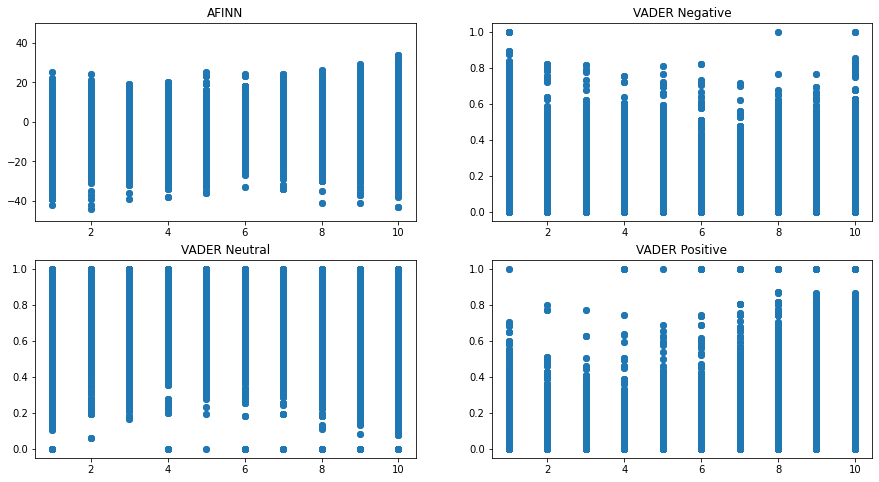

In [ ]:
## Plot all four sub-plots of sentiment predictions

fig, axs = plt.subplots(2, 2, figsize = (15,8))
axs[0, 0].scatter(fullDat.rating, fullDat.sent_AFINN)
axs[0, 0].set_title('AFINN')
axs[0, 0].set_ylim(-50, 50)
axs[0, 1].scatter(fullDat.rating, fullDat.sent_VADER_neg)
axs[0, 1].set_title('VADER Negative')
axs[1, 0].scatter(fullDat.rating, fullDat.sent_VADER_neu)
axs[1, 0].set_title('VADER Neutral')
axs[1, 1].scatter(fullDat.rating, fullDat.sent_VADER_pos)
axs[1, 1].set_title('VADER Positive')


There appears to be a rough positive correlations with AFINN and the positive VADER prediction. Running through a true correlation analysis to determine statistical correlation.

As hypothesized from the visuals, there does not appear to be a strong correlation between rating and any of the sentiment figures. Assuming we are capturing sentiment appropriately, it does not appear there is a strong relationships between sentiment and rating.

Reviewed introducing a spell checker but most text looks relatively clean and individual drugs names would need to be removed from spell check.

In [ ]:
fullDat[['rating', 'sent_AFINN', 'sent_VADER_neg', 'sent_VADER_neu', 'sent_VADER_pos']].corr()

,rating,sent_AFINN,sent_VADER_neg,sent_VADER_neu,sent_VADER_pos
rating,1.000000,0.284946,-0.268388,-0.020045,0.269879
sent_AFINN,0.284946,1.000000,-0.511012,0.035353,0.428196
sent_VADER_neg,-0.268388,-0.511012,1.000000,-0.562776,-0.260050
sent_VADER_neu,-0.020045,0.035353,-0.562776,1.000000,-0.650012
sent_VADER_pos,0.269879,0.428196,-0.260050,-0.650012,1.000000


### BERT Model

For this exploration, I am relying on the following walkthroughs for an implementation of BERT via GPU on Google Colab. The walkthroughs can be found [here](https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03) and [here](https://towardsdatascience.com/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613).

In [32]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

In [33]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    fullDat[fullDat.ID=='train'].review.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    fullDat[fullDat.ID=='test'].review.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(fullDat[fullDat.ID=='train'].rating.values - 1)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(fullDat[fullDat.ID=='test'].rating.values - 1)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [34]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(fullDat.rating.unique()),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [35]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [36]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)


In [37]:
possible_labels = (fullDat.rating-1).unique()
possible_labels.sort()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}

In [38]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [39]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       
        
        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'data_volume/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')


Epoch 1
Training loss: 1.435496596423335
Validation loss: 1.2062204670102392
F1 Score (Weighted): 0.5053893963356052



Epoch 2
Training loss: 1.2217607329657172
Validation loss: 0.9571198792943829
F1 Score (Weighted): 0.6333947335021746



Epoch 3
Training loss: 1.0411691539061794
Validation loss: 0.7342207913307562
F1 Score (Weighted): 0.744506863283779



Epoch 4
Training loss: 0.8994002137874547
Validation loss: 0.5952353204914955
F1 Score (Weighted): 0.804198518237673



Epoch 5
Training loss: 0.7983930754745043
Validation loss: 0.5296611539403013
F1 Score (Weighted): 0.8402028823121681



In [40]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('data_volume/finetuned_BERT_epoch_5.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: 0
Accuracy: 20597/21619

Class: 1
Accuracy: 4999/6931

Class: 2
Accuracy: 4561/6513

Class: 3
Accuracy: 2669/5012

Class: 4
Accuracy: 5869/8013

Class: 5
Accuracy: 3672/6343

Class: 6
Accuracy: 6092/9456

Class: 7
Accuracy: 15120/18890

Class: 8
Accuracy: 23588/27531

Class: 9
Accuracy: 48584/50989

